In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from mpmath import invertlaplace, exp, mp

1. Часовий проміжок - $[0, 10]$<br>
2. Генеруємо на ньому кількість страхових випадків, що розподілена за законом $n=Pois(\lambda\cdot t)$<br>
3. Генеруємо n незалежних величин $U(0, 10)$. Це є моменти часу настання страхових випадків.<br>
4. Генеруємо n незалежних страхових виплат, що згенеровані з щільністю $f_X(x)=2.5\cdot (x-2)^4$ для $x\in [1, 3]$ і 0 інкаше. В мові програмування Python не можна одразу згенерувати випадкову величину з таким розподілом. Тому будемо викручуватися. Знайшов дуже цікавий і відносно простий спосіб генерації величини за довільним законом. Для цього треба знайти оберену функцію розподілу. І підставити в якості параметра величину з рівномірного розподілу $U(0, 1)$.<br>Тобто треба виконати наступне: $y=F_X^{-1}\left(U(0, 1)\right)$ Тут -1 означає не степінь, а обернену функцію. У нас $F_X(x)=\frac{1}{2}(x-2)^5+\frac{1}{2}$. Її обернена: $F_X^{-1}(x)=\sqrt[5]{2x-1}+2$. Підставляємо замість х випадкову величину отриману з розподілу $U(0, 1)$.

In [2]:
def make_events(lambd, high):
    """
    Генерує випадкову кількість випадкових страхових виплат
    
    lambd - інтенсивність потоку Пуасона
    high - верхня межа для інтервалу. Ми генеруємо події на інтервалі [0, high]
    
    n - кіл-ть страхових випадків
    event_times - моменти настання страхових випадків
    events - розміри відповідних страхових виплат
    
    """
    n = np.random.poisson(lam = lambd)
    event_times = np.random.uniform(0, high, n)
    event_times.sort()
    
    x = np.random.uniform(0, 1, n)
    events = np.sign(2*x - 1) * np.abs(2*x - 1) ** (1/5) + 2
    return event_times, events

In [3]:
def sum_events(event_times, events, t):
    """
    Рахує суму страхових виплат що трапились до моменту часу t
    
    event_times - моменти настання страхових випадків
    events - розміри відповідних страхових виплат
    t - поточний час
    
    """
    if events.size == 0 or t < event_times[0]:
        return 0
    for i in range(1, events.size):
        if t>=event_times[i-1] and t<event_times[i]:
            return np.sum(events[:i])
    return np.sum(events)

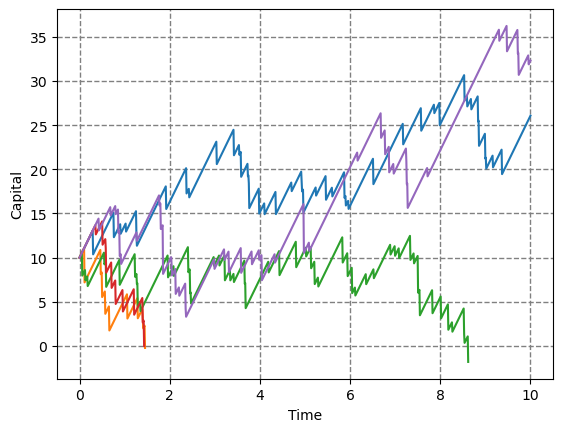

In [4]:
def make_plots(u0, c, lambd, time, num_plots):
    """
    Малює графіки траєкторій процесу Крамера-Лундберга
    
    u0 - початковий капітал
    с - страхові внески за одиницю часу
    lambd - середня кіл-ть страхових випадків за одиницю часу.
            Інтенсивність потоку Пуассона
    time - скільки моментів часу ми хочемо зобразити на графіку
    num_plots - кіл-ть траєкторій процесу Крамера-Лундберга
    
    """
    for i in range(0, num_plots):
        event_times, events = make_events(lambd*time, time)
        x = np.linspace(0, time, num=1000)
        y = np.zeros(1000)
        for i in range(0, 1000):
            y[i] = u0 + c*x[i] - sum_events(event_times, events, x[i])
            if y[i] < 0:
                x = x[:i+1]
                y = y[:i+1]
                break
        plt.plot(x, y)
    plt.xlabel("Time")
    plt.ylabel("Capital")
    plt.grid(axis='both', color='grey', linestyle='--', linewidth=1)
    plt.show()
    
make_plots(10, 10.5, 5, 10, 5)

Банкрутство може статись лише в момент страхової виплати. Тому треба відслідковувати не весь часовий відрізок [0, 1000], а окремі точки, коли стались страхові випадки і треба виплатити гроші.

In [5]:
def prob_ruin_rude_monte_carlo(u0, c, lambd, time, num_process):
    """
    Визначає ймовірність банкрутства грубим методом Монте-Карло
    
    u0 - початковий капітал
    с - страхові внески за одиницю часу
    lambd - середня кіл-ть страхових випадків за одиницю часу.
            Інтенсивність потоку Пуассона
    time - кількість моментів часу ми відслідковіємо
    num_process - кількість процесів, що моделюється
    
    ruin_num - кількість процесів, що збанкрутіли
    
    """
    ruin_num = 0
    
    for i in range(0, num_process):
        event_times, events = make_events(lambd*time, time)
        for i in range(0, event_times.size):
            y = u0 + c*event_times[i] - sum_events(event_times, events, event_times[i])
            if y < 0:
                ruin_num += 1
                break
                
    return ruin_num / num_process

### 6.1 Грубий метод Монте-Карло
Ймовірність банкрутства для першого випадку<br>
$\lambda=1, \;c=4, \; \mu=2, \; u_0=1$

In [6]:
# round(a, 6) - округлює число а до 6-ти знаків після коми
print( round(prob_ruin_rude_monte_carlo(u0=1, c=4, lambd=1, time=1000, num_process=1000), 6) )

0.371


### 6.2 Грубий метод Монте-Карло
Ймовірність банкрутства для другого випадку<br>
$\lambda=5, \;c=10.5, \; \mu=2, \; u_0=10$

In [7]:
# round(a, 6) - округлює число а до 6-ти знаків після коми
print( round(prob_ruin_rude_monte_carlo(u0=10, c=10.5, lambd=5, time=1000, num_process=1000), 6) )

0.668


In [8]:
def integ_tail_dist():
    """
    Генерує величину з розподілу "integrated tail distribution", що
    отриманий з заданого в умові
    
    Аналогічно, як і в функції make_events, ми генеруємо цю величину
    як значення оберненої функції розподілу від U(0, 1). Оскільки 
    в данному випадку в явному вигляді для відрізку [0.5, 1] оберненої
    функції не існує, то ми знаходимо її приблизне значення за допомогою
    методу fsolve з бібліотеки scipy. 
    
    """
    a = np.random.uniform(0, 1)
    if a <= 0.5:
        x_hat = 2*a
        return x_hat
    f = lambda x: 0.25*x - ((x-2)**6)/24 + 7/24-a  #integrated tail distribution - U(0, 1)
    x_hat = fsolve(f, 2)[0]
    return x_hat

In [9]:
def prob_ruin_accurate_monte_carlo(u0, c, lambd, num_iter):
    """
    Визначає ймовірність банкрутства більш точним методом Монте-Карло
    
    u0 - початковий капітал
    с - страхові внески за одиницю часу
    lambd - середня кіл-ть страхових випадків за одиницю часу.
            Інтенсивність потоку Пуассона
    num_iter - кількість процесів, що моделюється
    
    count - кількість процесів, що не збанкрутіли
    g - геометрично розподілена величина
    event - величина, отримана з перетворення integrated tail distribution
    
    """
    count = 0
    for k in range(0, num_iter):
        g = np.random.geometric(1-lambd*2/c) - 1
        summ = 0.
        for i in range(0, g):
            event = integ_tail_dist()
            summ += event
        if summ <= u0:
            count += 1
    return 1 - count / num_iter

### 7.1 Більш точний метод Монте-Карло
Ймовірність банкрутства для першого випадку<br>
$\lambda=1, \;c=4, \; \mu=2, \; u_0=1$

In [10]:
# round(a, 6) - округлює число а до 6-ти знаків після коми
print( round(prob_ruin_accurate_monte_carlo(u0=1, c=4, lambd=1, num_iter=1000), 6) )

0.362


### 7.2 Більш точний метод Монте-Карло
Ймовірність банкрутства для другого випадку<br>
$\lambda=5, \;c=10.5, \; \mu=2, \; u_0=10$

In [14]:
# round(a, 6) - округлює число а до 6-ти знаків після коми
print( round(prob_ruin_accurate_monte_carlo(u0=10, c=10.5, lambd=5, num_iter=1000), 6) )

0.638


### 8. Обернене перетворення Лапласа
Знайдемо ймовірність банкрутства. Чисельне знаходження оберненого перетворення Лапласа<br>
(дивись пункт 4)<br>
Використаємо вже готову функцію invertlaplace з бібліотеки mpmath.

Для першого випадку:
$f1(x) = \Phi(x)$, де $\Phi(x)$ ми взяли з 4-го пункту<br>
$x1$ - ймовірність небанкрутства

In [41]:
mp.dps = 15
f1 = lambda x: (4*x**5)/(8*x**6-2*x**5+exp(-3*x)*
                         ((exp(2*x)+1)*(-20*x**3-120*x)+(exp(2*x)-1)*(5*x**4+60*x**2+120)))

x1 = invertlaplace(f1, 1)
print(round(1-x1, 6))

0.357987


Для другого випадку:
$f2(x) = \Phi(x)$, де $\Phi(x)$ ми взяли з 4-го пункту<br>
$x2$ - ймовірність небанкрутства

In [42]:

f2 = lambda x: (x**5)/(21*x**6-10*x**5+exp(-3*x)*
                       ((exp(2*x)+1)*(-100*x**3-600*x)+(exp(2*x)-1)*(25*x**4+300*x**2+600)))

x2 = invertlaplace(f2, 10)
print(round(1-x2, 6))

0.640875


## Висновки
Загалом ми отримали:

Для грубого методу Монте-Карло: (1000 ітерацій)<br>
1. $P(банкрутство) = 0.371$
2. $P(банкрутство) = 0.668$

Для більш точного методу Монте-Карло: (1000 ітерацій)<br>
1. $P(банкрутство) = 0.362$
2. $P(банкрутство) = 0.638$

Для оберненого перетворення Лапласа:<br>
1. $P(банкрутство) = 0.357987$
2. $P(банкрутство) = 0.640875$

Грубий метод Монте-Карло є найгіршим варіантом. По-перше він є найбільш неточним. По-друге час його виконання є найбільшим. Мені треба було чекати близько 10-15 хвилин, поки він підрахує частку банкрутуючих процесів для другого випадку. Але він має одну перевагу - для нього не треба робити ніяких додаткових обчилень і знаходити додаткові розподіли як в інших випадках.

Більш точний метод Монте-Карло є значно кращим. По-перше він є точнішим завдяки тому, що він не обмежує тривалість процесу у часі, як грубий метод. Окрім того він значно швидший. Для другого випадку треба було чекати лише декілька секунд (а не 10-15 хв). Завдяки цьому його можна застосувати зі значно більшою кількістю ітерацій і отримати ще більш точні результати ніж у грубому методі. Але є один недолік порівняно із грубим методом - потрібно знайти додатковий розподіл Integrated Tail Distribution.

Чисельний метод розв'язання інтегрального рівняння через пряме і зворотнє перетворення Лапласа є найбільш точним, тому що при знаходжені відповіді відстутня будь-яка випадковість на відмінну від методів Монте-Карло. Можна знайти відповідь з довільною точністю. За замовчуванням - точність до 15 знаків після коми. Швидкість виконання є більшою за точний метод Монте-Карло. Тобто цей метод працює найшвидше і повертає найбільш точні результати. Але нам для цього треба знайти перетворення Лапласа і функцію $\Phi(p)$ що може бути дуже важким. Хоча, її також можна знайти наближено за допомогою чисельних методів, що вже реалізовані в різних бібліотеках Python.

Як бачимо, у 8-му пункті ми знайшли точні відповіді (якщо обмежитись лише 6-ма знаками після коми).<br>
Помилки для грубого методу:
1. $|0.357987 - 0.371| \approx 0.013$
2. $|0.640875-0.668| \approx 0.027$

Помилки для більш точного методу:
1. $|0.357987 - 0.362| \approx 0.0040$
2. $|0.640875-0.638| \approx 0.0029$

Як бачимо, більш точний метод Монте-Карло справді повернув результати, що є значно ближчими до істинного значення.